<a href="https://colab.research.google.com/github/lucius-yu/simple-learning/blob/main/build_a_generative_adversarial_network_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with pytorch: Build a Generative Adversarial Network

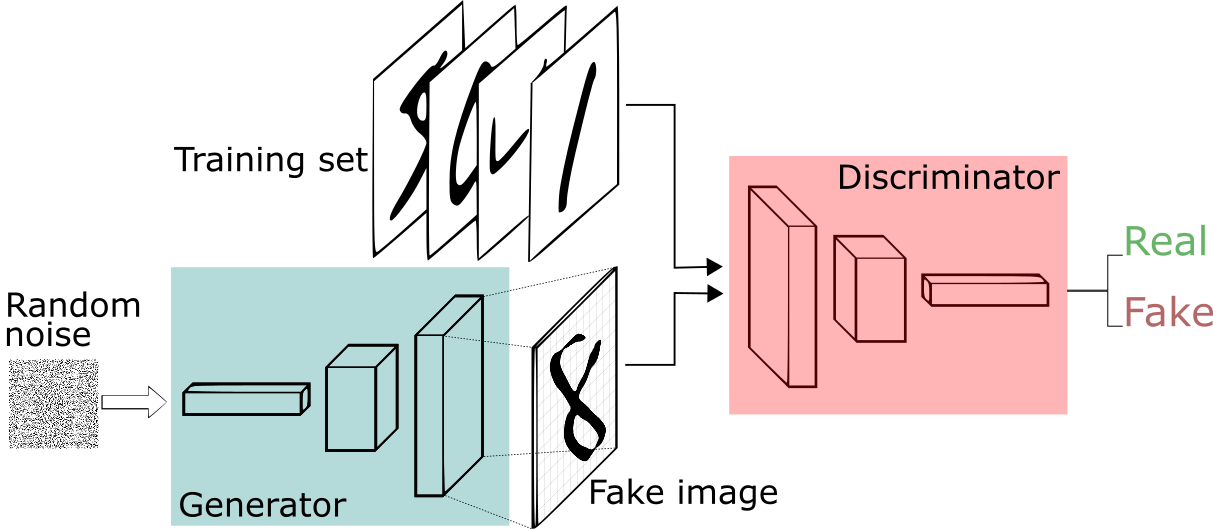

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Configurations

In [31]:
device = 'cuda' if torch.cuda.is_available() else "cpu"   # usage example: image = image.to(device)
batch_size = 128  # train loader, training loop
noise_dim = 64    # generator model

# optimizers parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

## Load MNIST Dataset

In [32]:
from torchvision import datasets, transforms as T

In [33]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor(), # Image is in numpy or PIL, transform to torch tensor (h, w, c) -> (c, h, w)
                  # Make sure the dimension of your images are (channel, height, width)
])

In [34]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

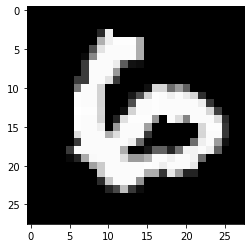

In [35]:
image, label = trainset[9000]

plt.imshow(image.squeeze(), cmap = 'gray')

In [36]:
print("total images present in trainset are : ", len(trainset))

total images present in trainset are :  60000


## Load Dataset into Batches

In [37]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [38]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [39]:
print("Total number of batches in trainloader : ", len(trainloader))

Total number of batches in trainloader :  469


In [40]:
dataiter = iter(trainloader)

images, _ = dataiter.next()

print(images.shape) # batch_size, channel, height, width

torch.Size([128, 1, 28, 28])


In [41]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1,28,28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

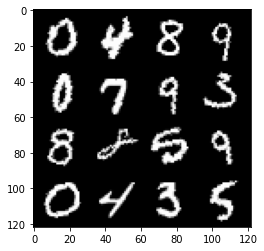

In [42]:
show_tensor_images(images, num_images = 16)

## Create Discriminator Network

It is a simple binary classifier, which classifies whether given image is a real image or a fake image

In [43]:
from torch import nn
from torchsummary import summary

In [44]:
'''

Network : Discriminator
bs is batch size
no max pooling
no sigmoid as final output, because we will use binary cross-entropy logit loss which take raw outputs as input. i.e. sigmoid is in logit-loss


input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''


'\n\nNetwork : Discriminator\nbs is batch size\nno max pooling\nno sigmoid as final output, because we will use binary cross-entropy logit loss which take raw outputs as input. i.e. sigmoid is in logit-loss\n\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU

In [45]:
from torch.nn.modules.activation import LeakyReLU
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        LeakyReLU(0.2)
    )

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5


In [47]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Create Generator network

We need to take the noise, shape (64,1) and generate picture as (1,28,28)

The 64 will be the number of channels. So on each channel, we only have one input, but we need to generate a picture 28 x 28. We need up-sampling

The technic used is ConvTranspose2d. # 叫做反卷积或者转置卷积


### 转置卷积

具体操作

原图输入尺寸为【1，3，3，3】对应【batch_size,channels,width,height】
反卷积tconv = nn.ConvTranspose2d(3,3,3,stride=2,padding=1)

#### 第一步：对输入的特征图做插值，在原先高宽方向的每两个相邻中间插上（Stride−1）列0，如下图所示，原来的尺寸为3*3，因为stride=2,则是在相邻行（列）之间插入(2-1)行（列）0

插入后的尺寸为为：height = height+(height-1)*(stride-1),这里也就是h=3+(2-1)(3-1)=5,即插值过后的 特征图为5*5

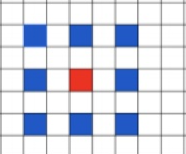


#### 第二步：求新的卷积核设置

新卷积核的kernel_new不变为3，stride_new恒为1，padding_new =(kernel_size - padding - 1) = 1

#### 第三步：用新的卷积核在新的特征图上做常规的卷积，得到的结果就是逆卷积的结果。

即在5*5的特征图上执行nn.conv(1,3,3,stride = 1,padding = 1),最后输出的特征图尺寸为：(5-3+2*1)/1+1=5

如下图，一个3x3的图像，通过反卷积成为5x5的图像

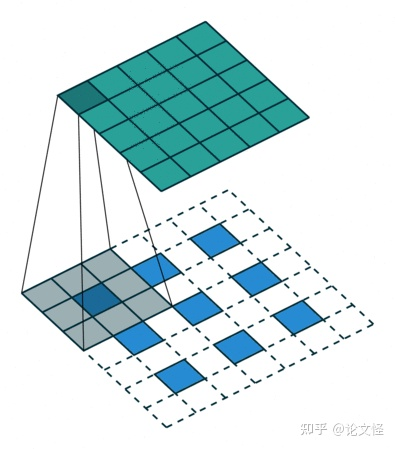

反卷积核的确定
卷积核的确定方式主要有两种，一是通过双线性插值固定卷积核的参数，不随着学习过程更新；二是随机初始化，并随着学习过程更新。

个人觉得随机初始化可能效果更好一点

In [48]:
'''
双线性插值固定卷积核参数代码

# 定义 bilinear kernel
def bilinear_kernel(in_channels, out_channels, kernel_size):
    #return a bilinear filter tensor
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

'''

"\n双线性插值固定卷积核参数代码\n\n# 定义 bilinear kernel\ndef bilinear_kernel(in_channels, out_channels, kernel_size):\n    #return a bilinear filter tensor\n    factor = (kernel_size + 1) // 2\n    if kernel_size % 2 == 1:\n        center = factor - 1\n    else:\n        center = factor - 0.5\n    og = np.ogrid[:kernel_size, :kernel_size]\n    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)\n    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')\n    weight[range(in_channels), range(out_channels), :, :] = filt\n    return torch.from_numpy(weight)\n\n"

In [49]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)                                            
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)                                            \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                    

In [50]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
        
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [51]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator,self).__init__()

        self.noise_dim = noise_dim

        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)

        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

    def forward(self, r_noise_vec):
        # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [52]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [53]:
# Replace Random initialized weights to Normal weights
'''
正态分布初始化
torch.nn.init.normal_(tensor, mean=0, std=1)

使值服从正态分布N(mean, std)，默认值为0，1
'''

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [54]:
D = D.apply(weights_init)
G = G.apply(weights_init)

## Create Loss Function Load Optimizer

Two Loss functions, Real and Fake Loss

For discriminator, we using binary cross entropy as loss function, defined as following 
$$ H(P|Q) = -(plogq + (1-p)log(1-q) $$

If the image is coming from real, P=1, we have real loss defined as $-(1*logD(x_r) + (1-1)*log(1-D(x_r)) = -logD(x_r)$

If the image is coming from fake, P=0, we have fake loss defined as $-(0*logD(x_f) + (1-0)*log(1-D(x_f)) = -log(1-D(x_f))$


In [55]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [56]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


## Training Loop

In [57]:
from tqdm import tqdm

100%|██████████| 469/469 [05:14<00:00,  1.49it/s]


Epoch : 0 | D_loss : 0.6796372975113549 | G_loss 0.7077450752258301


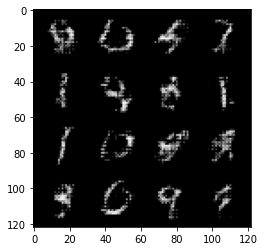

100%|██████████| 469/469 [05:13<00:00,  1.50it/s]


Epoch : 1 | D_loss : 0.651069926808892 | G_loss 0.7395572066307068


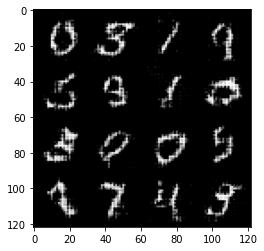

100%|██████████| 469/469 [05:13<00:00,  1.50it/s]


Epoch : 2 | D_loss : 0.6322213077087646 | G_loss 0.766042947769165


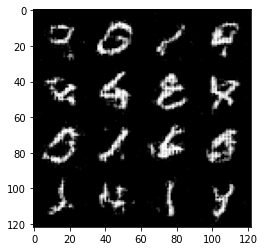

100%|██████████| 469/469 [05:13<00:00,  1.50it/s]


Epoch : 3 | D_loss : 0.6160332115728464 | G_loss 0.795566976070404


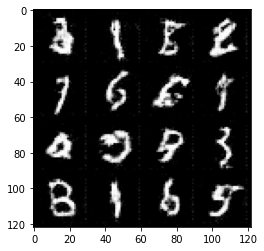

 47%|████▋     | 219/469 [02:26<02:46,  1.50it/s]

In [ ]:
for i in range(epochs):

    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):

        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        # find loss and update weights for D

        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2

        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # find loss and update weights for G

        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device = device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        # we want the discrimintor to think our generated images are real images. 
        # So we use real_loss as Generator Loss
        G_loss = real_loss(D_pred) 

        total_g_loss += G_loss

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch : {} | D_loss : {} | G_loss {}".format(i, avg_d_loss, avg_g_loss))

    show_tensor_images(fake_img)

# Other calculation

In [59]:
# According to height, weight, kernel and stride to calculate discriminator output shape 

def get_shape(h,w,k_h, k_w,s):
    return np.floor((h-k_h+s)/s), np.floor((w-k_w+s)/s)

def get_out_shape(h,w):
    shape_1 = get_shape(h,w,3,3,2)
    shape_2 = get_shape(shape_1[0],shape_1[1],5,5,2)
    shape_3 = get_shape(shape_2[0],shape_2[1],5,5,2)
    shape_flatten = shape_3[0]*shape_3[1]
    return shape_flatten

# for input shape as 28x28
print(get_out_shape(28,28))
print(get_out_shape(36,36))

1.0
4.0
